In [3]:
# Calculation of complete reporting rates with program and stock data

%matplotlib inline  
# !pip install matplotlib

import pandas as pd
import numpy as np
import pandas_highcharts.core
from sqlalchemy import create_engine
import psycopg2
import matplotlib.pyplot 

# weird construct - if you don't from * import * you have to use datetime.datetime in commands
from datetime import datetime, date, timedelta

import os

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "IMAM.settings")

from django.conf import settings
from home.management.commands.load_data import rename_cols, assign_state_lga_num

import django
django.setup()

# is this line necessary?
from home.models import Program, Stock, Site

In [4]:
# Import Program Data
engine = create_engine(
    'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{NAME}'.format(**settings.DATABASES['default']))
df = pd.read_sql_query("select * from program;", con=engine)

In [270]:
!pip install isoweek

In [1]:
!pip freeze

appdirs==1.4.0
backports-abc==0.5
backports.shutil-get-terminal-size==1.0.0
bleach==1.5.0
certifi==2017.1.23
configparser==3.5.0
coverage==4.3.4
cycler==0.10.0
decorator==4.0.11
Django==1.10.5
entrypoints==0.2.2
enum34==1.1.6
functools32==3.2.3.post2
html5lib==0.9999999
ipykernel==4.5.2
ipython==5.2.2
ipython-genutils==0.1.0
ipywidgets==5.2.2
isoweek==1.3.3
Jinja2==2.9.5
jsonschema==2.6.0
jupyter==1.0.0
jupyter-client==4.4.0
jupyter-console==5.1.0
jupyter-core==4.3.0
MarkupSafe==0.23
matplotlib==2.0.0
mistune==0.7.3
nbconvert==5.1.1
nbformat==4.2.0
notebook==4.4.1
numpy==1.12.0
packaging==16.8
pandas==0.19.2
pandas-highcharts==0.5.2
pandocfilters==1.4.1
pathlib2==2.2.1
pexpect==4.2.1
pickleshare==0.7.4
prompt-toolkit==1.0.13
psycopg2==2.6.2
ptyprocess==0.5.1
Pygments==2.2.0
pyparsing==2.1.10
python-dateutil==2.6.0
pytz==2016.10
pyzmq==16.0.2
qtconsole==4.2.1
scandir==1.4
simplegeneric==0.8.1
singledispatch==3.4.0.3
six==1.10.0
SQLAlchemy==1.1.5
subprocess32==3.2.7
terminado==0.6
testpa

In [5]:
# Follow order for cleaning data for graph
#  - convert from string to float
#  - filter out incorrect data with query
#  - convert from float to int

df['siteid'] = pd.to_numeric(df.siteid, errors='coerce')
df['weeknum'] = pd.to_numeric(df.weeknum, errors='coerce')

df = df.query('siteid==siteid').query('0<siteid<3999990999')
# 2015 had 53 weeks
# 2016 had 52 weeks - current data is only for weeknumbers from 22-2016 to present
df = df.query('weeknum==weeknum').query('0.99<weeknum<53')

df['siteid'] = df.siteid.astype('int')
df['weeknum'] = df.weeknum.astype('int')

In [6]:
# Before filter - Sort data
df = df.sort_values(by='last_seen', ascending = False)
len(df)

36052

In [7]:
# Filter one entry per weeknum
df = df.drop_duplicates(['siteid', 'weeknum', 'type'], keep ='first')
len(df)

24168

In [8]:
# count of number of rows with each unique value of var
df.type.value_counts()

OTP    21963
SC      1870
Name: type, dtype: int64

In [9]:
# number of distinct values in column
len(df['type'].unique())

3

In [10]:
# the unique values for var in column
df.type.unique()

array([u'OTP', u'SC', None], dtype=object)

In [11]:
df.confirm.value_counts()

Yes      23168
No          79
Other       34
X            1
Name: confirm, dtype: int64

In [12]:
# to make reporting rates need to identify all data in past 8 weeks

# create today's weeknum

# create weeknum / year of report date

#for range in todays weeknum-8 to todays weeknum
#   count number of valid reports for program and stocks
#   divide total over 16 (8 entries for program and 8 for stock)

In [13]:
# print datetime.now(), type(datetime.now())
# 2017-03-29 15:32:15.342119 

#df.last_seen
# 2017-03-20 07:12:32

#datetime and numpy date64 appear the same

#rep_week = date(2017, 1, 1).isocalendar()
#rep_week

#df.rep_weeknum = date(df.last_seen).strftime("%V")
#df.rep_weeknum = date(df.last_seen).isocalendar()
# cannot use python commands on dataframes ?

#df=df.assign(rep_weeknum=lambda df: date(df.last_seen).isocalendar())

# this did not work when test, but now appears to work
df['rep_year_wn'] = df['last_seen'].map(lambda x: x.isocalendar())

#import time
#from time import gmtime, strftime
#df.rep_weeknum = time(df.last_seen, "%Y %m %d")
# print(strftime("%W", df.rep_weeknum))

# This works but is a hack because there is an error between year and week number
df['rep_year'] = df['last_seen'].map(lambda x: x.to_pydatetime().isocalendar()[0])

# double check if the week number below is ISO standard
# I don't know the reference for week below, but appears to be ISO week
df['rep_weeknum'] = df['last_seen'].map(lambda x: x.to_pydatetime().isocalendar()[1])
                                        
# Isocalendar is better to use as it tracks (year, weeknum, day of week)                                        

In [10]:
df['last_seen'][0]

Timestamp('2016-10-06 17:01:37')

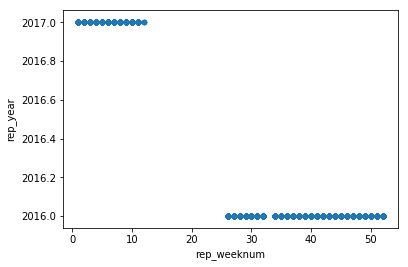

In [11]:
df.plot.scatter(x='rep_weeknum', y='rep_year')
# problem with week number 52 year 2017

In [14]:
# clean data

# delete all future reporting -before 10 am on the first day of the report week. 
df['last_seen_dotw'] = df['last_seen'].map(lambda x: x.to_pydatetime().isocalendar()[2])
df['last_seen_hour'] = df['last_seen'].map(lambda x: x.to_pydatetime().hour)
#df.query('last_seen_dotw==1').query('last_seen_hour<10').query('rep_weeknum==weeknum')['name'].groupby(df['name']).count().plot(kind='bar', rot=90)
bad_index = df.query('last_seen_dotw==1').query('last_seen_hour<10').query('rep_weeknum==weeknum').index.tolist()


# print df.count()
df = df[~df.index.isin(bad_index)]

In [15]:
df['last_seen_weeknum_8weekago'] = df['last_seen'].map(lambda x: (x.to_pydatetime() - timedelta(weeks=8)).isocalendar()[1])

In [16]:
(9 - 46) % 52

15

In [15]:
df.head()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,role,...,dmed,tout,confirm,unique,rep_year_wn,rep_year,rep_weeknum,last_seen_dotw,last_seen_hour,last_seen_weeknum_8weekago
34607,34499,1fed4097-3edb-44ec-a04d-3dd8fd0f46a7,2348068838496,Hussain Umar Zamni.,"Imam Supervision, Imam Supervision 2, Imam Sup...",818110008,2017-03-20 07:10:19,2017-03-20 07:12:32,11,Site,...,None,None,None,2348068838496 2017-03-20 07:10:19,"(2017, 12, 1)",2017,12,1,7,4
27735,27625,893376dd-9df2-4a91-8f21-5e68cf724b41,2347069118684,Samaila Sulaiman .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603210001,2017-03-20 07:10:08,2017-03-20 07:12:30,8,Site,...,None,None,None,2347069118684 2017-03-20 07:10:08,"(2017, 12, 1)",2017,12,1,7,4
28082,27970,d745fc85-ffae-4cfc-935c-267a16bd7bca,2348067698638,Nafiu Bello.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3605110051,2017-03-20 07:04:00,2017-03-20 07:10:05,11,Site,...,0.0,2,Yes,2348067698638 2017-03-20 07:04:00,"(2017, 12, 1)",2017,12,1,7,4
25619,25522,eadd9870-9e6a-483d-9669-97291071efe5,2347031104215,Abdullah Maaruf.,"AlertRUTF, Imam Supervision, Imam Supervision ...",2034110031,2017-03-20 06:42:09,2017-03-20 06:46:13,11,Site,...,0,0,Yes,2347031104215 2017-03-20 06:42:09,"(2017, 12, 1)",2017,12,1,6,4
3979,3959,c6ace209-1c2e-46f2-b008-950715e39df2,2348166722275,Abdulwahab Ismail.,"Imam Supervision, Imam Supervision 2, Imam Sup...",1606110027,2017-03-19 22:47:40,2017-03-19 23:16:51,11,Site,...,1,0,Yes,2348166722275 2017-03-19 22:47:40,"(2017, 11, 7)",2017,11,7,23,3


In [17]:
df['year'] = df['last_seen'].map(lambda x: x.year)

df['last_seen_weeknum'] = df['last_seen'].map(lambda x: x.week)
df['year'] = np.where(df['last_seen_weeknum'] < df['weeknum'],
                                        df['year'] - 1, df['year'])

df['year_weeknum'] = zip(df['year'], df['weeknum'])

In [18]:
# from isoweek import Week
# w = Week(2011, 20)

from isoweek import Week
df['iso_rep_year_wn'] = df['rep_year_wn'].map(lambda x: Week(x[0], x[1]))

df['iso_year_weeknum'] = df['year_weeknum'].map(lambda x: Week(x[0], x[1]))

In [19]:
# Remove all reports for dates in the future.
bad_index2 = df.query('rep_year_wn<year_weeknum').index.tolist()
df = df[~df.index.isin(bad_index2)]

In [20]:
# this mean that iso week comparison yield the sane result than tuple comparison
((df['iso_rep_year_wn'] >= df['iso_year_weeknum']) == (df['rep_year_wn'] >= df['year_weeknum'])).describe()

count     24111
unique        1
top        True
freq      24111
dtype: object

In [22]:
df['iso_diff'] = (df['iso_year_weeknum'] - df['iso_rep_year_wn'] )
# iso_diff is the number of weeks between the last_seen weeknum and weeknum
# clarify this language
df['iso_diff'].groupby(df['iso_diff']).count().describe()

count      52.000000
mean      463.673077
std      1346.973976
min         1.000000
25%         5.750000
50%        14.500000
75%        76.000000
max      7848.000000
Name: iso_diff, dtype: float64

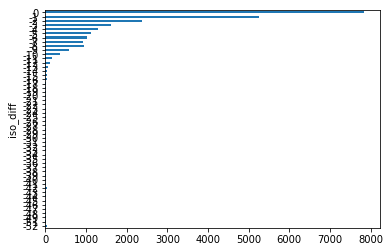

In [22]:
df['iso_diff'].groupby(df['iso_diff']).count().plot.barh()

In [332]:
df['iso_diff'].groupby(df['iso_diff']).count()

iso_diff
-52      45
-51       4
-49       1
-48       9
-47       5
-46       1
-45       2
-44       9
-43      17
-42      27
-41      14
-40      18
-39      12
-38       4
-37       2
-36       3
-35      13
-34       8
-33       8
-32       2
-31       2
-30       4
-29       5
-28       5
-27      11
-26       6
-25      15
-24       6
-23       7
-22      14
-21      11
-20      16
-19      19
-18      21
-17      24
-16      32
-15      30
-14      40
-13      68
-12     100
-11     166
-10     346
-9      573
-8      952
-7      920
-6     1012
-5     1115
-4     1284
-3     1612
-2     2382
-1     5261
 0     7848
Name: iso_diff, dtype: int64

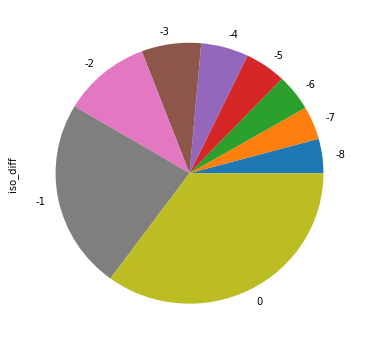

In [23]:
# remove reports for 8 weeks prior to report date
df.query('iso_diff>=-8')['iso_diff'].groupby(df['iso_diff']).count().plot.pie(figsize=(6, 6))

# reporting by the day of the week

In [24]:
year, week, dotw = date.today().isocalendar()
current_week = Week(year, week)

# since how many week this report is about
df['since_x_weeks'] = df['iso_year_weeknum'].map(lambda x: current_week - x)

In [37]:
df.query('since_x_weeks<=8')['since_x_weeks']
# length of time between current week and report week

34607    2
27735    5
28082    2
25619    2
3979     2
27817    2
20069    2
911      2
27816    3
19641    4
28551    2
19640    8
4543     2
10485    2
20143    2
20142    3
3900     2
20141    4
20140    5
27734    6
34532    2
27563    2
13539    3
32246    2
27732    7
26778    2
14672    2
14770    2
26777    3
25921    2
        ..
34116    8
25969    8
17875    8
21485    8
34069    8
1762     8
8080     8
11159    8
33919    8
22146    8
28581    8
13262    8
4951     8
23490    8
30137    8
24536    8
26929    8
3853     8
28166    8
18564    8
26558    8
36120    8
27147    8
20976    8
6096     8
17714    8
27677    8
10221    8
25429    8
5488     8
Name: since_x_weeks, dtype: int64

In [74]:
df.query('since_x_weeks<=8').query('siteid>101110001').groupby(df['siteid'])['weeknum'].count()

siteid
201110007     4
201110009     5
201110026     4
201110029     4
201410014     5
202110019     3
202110021     6
202110027     6
202110035     6
202110068     5
202610001     4
203110002     6
203110037     6
203110038     6
203110043     6
203110053     6
204110006     5
204110014     4
204110026     5
204110029     6
204110035     6
205110025     5
205110030     3
206110004     6
206110011     6
206110020     5
206110032     2
206110034     6
207110055     6
207110082     5
             ..
3605110016    5
3605110020    4
3605110027    5
3605110035    6
3605110051    6
3605110056    5
3605110058    6
3605110063    6
3605210026    5
3607210005    6
3607210063    6
3607210081    6
3607310003    5
3609110002    6
3609110014    6
3609110026    6
3609110043    6
3609210040    5
3611110009    6
3611110018    6
3611110022    6
3611110026    6
3611110033    4
3611210034    5
3613110001    6
3613110010    6
3613110022    6
3613110044    6
3613110051    6
3613210035    1
Name: weeknum, dt

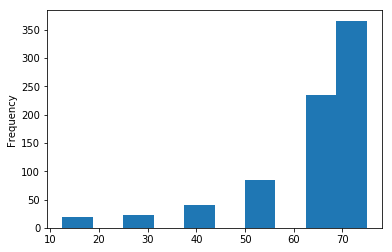

In [26]:
df.query('since_x_weeks<=8').query('siteid>101110001').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).plot.hist()

In [27]:
set(range(5, 13))

{5, 6, 7, 8, 9, 10, 11, 12}

In [28]:
# set operation to calculate missing report week nubers
set(range(5, 13)) - set([9, 8, 7, 6, 5])

{10, 11, 12}

In [29]:
week = date.today().isocalendar()[1]
range(week - 8, week)

[6, 7, 8, 9, 10, 11, 12, 13]

In [30]:
# making things generic
set(range(week - 8, week)) - set([9, 8, 7, 6, 5])

{10, 11, 12, 13}

In [31]:
# missing weeks
df.query('since_x_weeks<=8').query('siteid>101110001').groupby(df['siteid'])['weeknum'].unique().map(lambda x: set(range(week - 8, week)) - set(x))

siteid
201110007              {10, 11, 12, 13}
201110009                  {11, 12, 13}
201110026              {10, 11, 12, 13}
201110029               {9, 11, 12, 13}
201410014                   {8, 12, 13}
202110019           {9, 10, 11, 12, 13}
202110021                      {12, 13}
202110027                      {12, 13}
202110035                      {12, 13}
202110068                  {11, 12, 13}
202610001              {10, 11, 12, 13}
203110002                      {12, 13}
203110037                      {12, 13}
203110038                      {12, 13}
203110043                      {12, 13}
203110053                      {12, 13}
204110006                  {11, 12, 13}
204110014              {10, 11, 12, 13}
204110026                  {11, 12, 13}
204110029                      {12, 13}
204110035                      {12, 13}
205110025                  {11, 12, 13}
205110030           {9, 10, 11, 12, 13}
206110004                      {12, 13}
206110011                      {1

In [52]:
df = assign_state_lga_num(df)

In [32]:
# percentage of complet reporting for one site
df.query('since_x_weeks<=8').query('siteid>101110001').query('3611110033==siteid').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).tolist()[0]

50.0

In [55]:
df['lga_num'].unique()

array(['818', '3603', '3605', '2034', '1606', '3611', '202', '3308', '204',
       '3613', '513', '3512', '1609', '3501', '2106', '3609', '3507',
       '2026', '813', '3509', '1714', '3514', '2104', '2033', '1727',
       '3513', '3517', '3502', '3510', '2102', '212', '819', '1704',
       '1940', '1604', '812', '3319', '3504', '2027', '2004', '821',
       '3508', '802', '2105', '2113', '3505', '1', '1921', '2117', '2112',
       '1905', '816', '2109', '2018', '206', '1710', '2114', '1702',
       '1818', '827', '3306', '2024', '1724', '1716', '1944', '3511',
       '3304', '2003', '1928', '3305', '504', '3503', '2118', '3301',
       '203', '3317', '1936', '201', '2108', '2001', '804', '2015', '2016',
       '2007', '208', '1719', '512', '3321', '1823', '221', '2115', '2111',
       '2005', '1717', '3602', '2011', '1712', '1703', '2103', '805',
       '3516', '3607', '218', '220', '2010', '215', '1731', '205', '1720',
       '207', '217', '213', '3313', '3515', '3506', '814', '211',

In [61]:
df.query('since_x_weeks<=8').groupby(df['lga_num']).count()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,role,...,year,last_seen_weeknum,year_weeknum,iso_rep_year_wn,iso_year_weeknum,iso_diff,since_x_weeks,siteid_lgt,state_num,lga_num
lga_num,,,,,,,,,,,,,,,,,,,,,
101,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1604,29,29,29,29,29,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
1606,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
1609,25,25,25,25,25,25,25,25,25,25,...,25,25,25,25,25,25,25,25,25,25
1702,33,33,33,33,33,33,33,33,33,33,...,33,33,33,33,33,33,33,33,33,33
1703,55,55,55,55,55,55,55,55,55,55,...,55,55,55,55,55,55,55,55,55,55
1704,37,37,37,37,37,37,37,37,37,37,...,37,37,37,37,37,37,37,37,37,37
1706,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
1709,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5


In [64]:
df.query('since_x_weeks<=8').query('lga_num=="3603"')

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,role,...,year,last_seen_weeknum,year_weeknum,iso_rep_year_wn,iso_year_weeknum,iso_diff,since_x_weeks,siteid_lgt,state_num,lga_num
27735,27625,893376dd-9df2-4a91-8f21-5e68cf724b41,2347069118684,Samaila Sulaiman .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603210001,2017-03-20 07:10:08,2017-03-20 07:12:30,8,Site,...,2017,12,"(2017, 8)","(2017, 12)","(2017, 8)",-4,6,10,36,3603
27734,27624,893376dd-9df2-4a91-8f21-5e68cf724b41,2347069118684,Samaila Sulaiman .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603210001,2017-03-19 19:39:08,2017-03-19 19:43:49,7,Site,...,2017,11,"(2017, 7)","(2017, 11)","(2017, 7)",-4,7,10,36,3603
27732,27622,893376dd-9df2-4a91-8f21-5e68cf724b41,2347069118684,Samaila Sulaiman .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603210001,2017-03-19 18:18:32,2017-03-19 18:23:23,6,Site,...,2017,11,"(2017, 6)","(2017, 11)","(2017, 6)",-5,8,10,36,3603
27472,27363,661ce0cb-5713-4940-825e-143dae67e8c3,2347030380472,Tukur Ahmed .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603110012,2017-03-15 12:17:18,2017-03-15 12:23:00,10,Site,...,2017,11,"(2017, 10)","(2017, 11)","(2017, 10)",-1,4,10,36,3603
27755,27645,a4cc3b22-0360-4301-9a6e-b10d0b6731e8,2348086250026,Salisu Abdullahi.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603110018,2017-03-13 16:45:33,2017-03-13 16:51:23,10,Site,...,2017,11,"(2017, 10)","(2017, 11)","(2017, 10)",-1,4,10,36,3603
36955,36943,c358d9d3-4d20-46d7-9ba5-123ba4fe3fb8,2348080624352,MANDE SANI.,"No_Email, No_Post, No_SiteID, Nut Personnel",3603110029,2017-03-08 20:46:02,2017-03-08 20:51:19,10,Site,...,2017,10,"(2017, 10)","(2017, 10)","(2017, 10)",0,4,10,36,3603
27684,27574,ca4b9112-0a18-4b7d-920e-182b2134cefe,2348163609837,Mujahid Abdullahi.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603110037,2017-03-07 20:20:06,2017-03-07 20:29:57,9,Site,...,2017,10,"(2017, 9)","(2017, 10)","(2017, 9)",-1,5,10,36,3603
27683,27573,ca4b9112-0a18-4b7d-920e-182b2134cefe,2348163609837,Mujahid Abdullahi.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603110037,2017-03-07 11:46:13,2017-03-07 11:55:17,10,Site,...,2017,10,"(2017, 10)","(2017, 10)","(2017, 10)",0,4,10,36,3603
27744,27634,a4cc3b22-0360-4301-9a6e-b10d0b6731e8,2348086250026,Salisu Abdullahi.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603110018,2017-03-06 18:15:01,2017-03-06 18:21:20,9,Site,...,2017,10,"(2017, 9)","(2017, 10)","(2017, 9)",-1,5,10,36,3603
27471,27362,661ce0cb-5713-4940-825e-143dae67e8c3,2347030380472,Tukur Ahmed .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603110012,2017-03-03 11:26:13,2017-03-03 11:34:16,9,Site,...,2017,9,"(2017, 9)","(2017, 9)","(2017, 9)",0,5,10,36,3603


In [70]:
# percentage of complet reporting for one site
df.query('since_x_weeks<=8').query('"3603"==lga_num').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).mean()

56.25

In [71]:
# percentage of complet reporting for one site
df.query('since_x_weeks<=8').query('"3603"==lga_num').groupby(df['lga_num'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100)

lga_num
3603    62.5
Name: weeknum, dtype: float64

In [77]:
# percentage of complet reporting for one site
df.query('since_x_weeks<=8').query('"33"==state_num').groupby(df['siteid'])['weeknum'].count().map(lambda x: (x / 8.) * 100).mean()

65.686274509803923

In [47]:
# percentage of complet reporting for one site
df.query('since_x_weeks<=8').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).mean()

84.722222222222229

In [43]:
current_week.week - df['last_seen'].max().week


2

In [77]:
(5 / 8.) * 100

62.5

In [71]:
df['since_x_weeks'].max()

91

In [81]:
for i in range(0, df['since_x_weeks'].max()):
    print i, df.query('%s<since_x_weeks<=%s' % (i, i + 8)).query('siteid>101110001').query('3611110033==siteid').groupby(df['siteid'])['weeknum'].unique().map(lambda x: (len(x) / 8.) * 100).tolist()

0 [62.5]
1 [75.0]
2 [87.5]
3 [100.0]
4 [100.0]
5 [100.0]
6 [100.0]
7 [100.0]
8 [100.0]
9 [100.0]
10 [100.0]
11 [100.0]
12 [100.0]
13 [100.0]
14 [100.0]
15 [100.0]
16 [100.0]
17 [100.0]
18 [100.0]
19 [100.0]
20 [100.0]
21 [100.0]
22 [87.5]
23 [75.0]
24 [62.5]
25 [50.0]
26 [37.5]
27 [25.0]
28 [12.5]
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []


In [98]:
x, y = [], []
for i in range(0, df['since_x_weeks'].max()):
    w = current_week - i
    print w, len(df.query('%s<since_x_weeks<=%s' % (i, i + 8))['siteid'].unique())
    x.append(df['since_x_weeks'].max() - i) 
    y.append(len(df.query('%s<since_x_weeks<=%s' % (i, i + 8))['siteid'].unique()))

2017W14 770
2017W13 776
2017W12 801
2017W11 818
2017W10 825
2017W09 828
2017W08 836
2017W07 841
2017W06 845
2017W05 847
2017W04 850
2017W03 850
2017W02 854
2017W01 851
2016W52 854
2016W51 855
2016W50 857
2016W49 860
2016W48 861
2016W47 860
2016W46 857
2016W45 851
2016W44 863
2016W43 867
2016W42 859
2016W41 844
2016W40 813
2016W39 804
2016W38 791
2016W37 761
2016W36 503
2016W35 410
2016W34 399
2016W33 373
2016W32 351
2016W31 186
2016W30 176
2016W29 168
2016W28 159
2016W27 112
2016W26 87
2016W25 81
2016W24 82
2016W23 77
2016W22 38
2016W21 36
2016W20 38
2016W19 38
2016W18 33
2016W17 33
2016W16 32
2016W15 34
2016W14 29
2016W13 24
2016W12 19
2016W11 15
2016W10 21
2016W09 110
2016W08 108
2016W07 110
2016W06 110
2016W05 111
2016W04 111
2016W03 110
2016W02 109
2016W01 9
2015W53 14
2015W52 13
2015W51 15
2015W50 15
2015W49 14
2015W48 14
2015W47 13
2015W46 14
2015W45 12
2015W44 9
2015W43 7
2015W42 6
2015W41 2
2015W40 2
2015W39 2
2015W38 1
2015W37 0
2015W36 1
2015W35 2
2015W34 2
2015W33 2
2015W32 

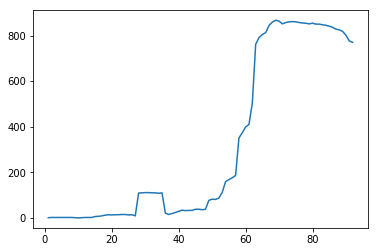

In [99]:
# number of active sites reporting in past 8 weeks
matplotlib.pyplot.plot(x, y)

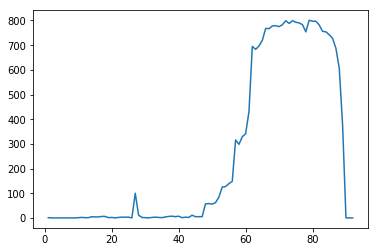

In [101]:
x, y = [], []
for i in range(0, df['since_x_weeks'].max()):
    w = current_week - i
    x.append(df['since_x_weeks'].max() - i) 
    y.append(len(df.query('%s==since_x_weeks' % (i))['siteid'].unique()))
    
matplotlib.pyplot.plot(x, y)

In [29]:
52 / 8.

6.5

In [108]:
df.head()

,index,contact_uuid,urn,name,groups,siteid,first_seen,last_seen,weeknum,role,...,tin,dcur,dead,defu,dmed,tout,confirm,unique,rep_weeknum,rep_year
34607,34499,1fed4097-3edb-44ec-a04d-3dd8fd0f46a7,2348068838496,Hussain Umar Zamni.,"Imam Supervision, Imam Supervision 2, Imam Sup...",818110008,2017-03-20 07:10:19,2017-03-20 07:12:32,11,Site,...,0,None,None,None,None,None,None,2348068838496 2017-03-20 07:10:19,12,2017
27735,27625,893376dd-9df2-4a91-8f21-5e68cf724b41,2347069118684,Samaila Sulaiman .,"Imam Supervision, Imam Supervision 2, Imam Sup...",3603210001,2017-03-20 07:10:08,2017-03-20 07:12:30,8,Site,...,0,None,None,None,None,None,None,2347069118684 2017-03-20 07:10:08,12,2017
28082,27970,d745fc85-ffae-4cfc-935c-267a16bd7bca,2348067698638,Nafiu Bello.,"Imam Supervision, Imam Supervision 2, Imam Sup...",3605110051,2017-03-20 07:04:00,2017-03-20 07:10:05,11,Site,...,0,2.0,0.0,0.0,0.0,2,Yes,2348067698638 2017-03-20 07:04:00,12,2017
25619,25522,eadd9870-9e6a-483d-9669-97291071efe5,2347031104215,Abdullah Maaruf.,"AlertRUTF, Imam Supervision, Imam Supervision ...",2034110031,2017-03-20 06:42:09,2017-03-20 06:46:13,11,Site,...,0,0,0,0,0,0,Yes,2347031104215 2017-03-20 06:42:09,12,2017
3979,3959,c6ace209-1c2e-46f2-b008-950715e39df2,2348166722275,Abdulwahab Ismail.,"Imam Supervision, Imam Supervision 2, Imam Sup...",1606110027,2017-03-19 22:47:40,2017-03-19 23:16:51,11,Site,...,0,6,0,0,1,0,Yes,2348166722275 2017-03-19 22:47:40,11,2017


In [23]:
df['rep_iso'] = df['last_seen'].map(lambda x: x.isocalendar())
# why is this working now and not yesterday ? 

In [24]:
df['rep_iso'].head()

34607    (2017, 12, 1)
27735    (2017, 12, 1)
28082    (2017, 12, 1)
25619    (2017, 12, 1)
3979     (2017, 11, 7)
Name: rep_iso, dtype: object

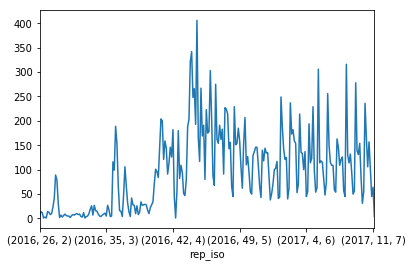

In [208]:
entries_by_week = df['rep_iso'].groupby(df['rep_iso']).count()
entries_by_week.plot()
# here can see the sine wave related to reporting by week day

In [183]:
# calculate ISO year, weeknum, day for var weeknum



# take first value (year) out of rep_weeknum (year, weeknum, day)
df['rep_year'] = df['last_seen'].map(lambda x: x.isocalendar()[0])
df['rep_weeknum'] = df['last_seen'].map(lambda x: x.isocalendar()[1])

df['rep_weeknum'].unique()

array([12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1, 52, 51, 50, 49, 48,
       47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 32, 31, 30,
       29, 28, 27, 26])

In [ ]:
firstjan = datetime(2010, 1, 1).isocalendar()
fourjan = datetime(2010, 1, 4).isocalendar()
print firstjan, type(firstjan)
print fourjan
#print fourjan - firstjan
# Cannot add and subtract from two instances of isocalendar

In [150]:
# to extract a date from isocalendar tuple
# in python 3.6
# datetime.strptime('2010 1 1','%G %V %u').date()

# Create an isocalendar tuple and assign it to isocalendar format
#df['weeknum_date'] = datetime(df['rep_year'],df['weeknum'],1).isocalendar()
#df['weeknum_date'] = datetime(df['rep_year'],df['weeknum'],1).map(lambda x: x.isocalendar())
# Is weeknum a string? NO - This is not the problem
# isocalendar takes a date as input
df['year_wn'] =list(zip(df['rep_year'], df['weeknum']))

In [162]:
# Either create two dates and subtract, or
# subtract the rep_week from weeknum and correct the year

# create date from week number
d = "2017-W1"
r = datetime.strptime(d + '-0', "%Y-W%W-%w")
print r
# does not use ISO week numbers - do not use

#from isoweek import Week
#w = Week(2016, 52)
#print "Week %s starts on %s" % (w, w.monday())
# no module named isoweek

2017-01-08 00:00:00


In [210]:
# to convert iso week number to correct date 
# either change to Python 3.6 or
# calculate first week of year and then convert week number to date, correcting year. 

df['weekdiff'] = df.weeknum - df.rep_weeknum 
# When creating new variables, you cannot refer to the new variable as df.weekdiff

# Change the order (the index) of the columns
columnsTitles = ['weeknum',
                'rep_weeknum',
                 'weekdiff']

df2 = df.reindex(columns=columnsTitles)
df2

,weeknum,rep_weeknum,weekdiff
34607,11,12,-1
27735,8,12,-4
28082,11,12,-1
25619,11,12,-1
3979,11,11,0
27817,11,11,0
20069,11,11,0
911,11,11,0
27816,10,11,-1
19641,9,11,-2


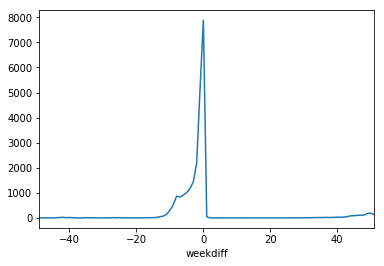

In [211]:
# Univariate plot of values by count of value
wd = df['weekdiff'].groupby(df['weekdiff']).count()
wd.plot()
# have to correct the values that are near weeknum 46

In [189]:
print wd

weekdiff
-49      1
-48      8
-47      2
-45      1
-44      8
-43     15
-42     26
-41     10
-40     18
-39     11
-38      3
-37      1
-36      2
-35     11
-34      7
-33      7
-32      2
-31      1
-30      2
-29      3
-28      3
-27     10
-26      3
-25     13
-24      3
-23      2
-22      6
-21      4
-20      7
-19      5
      ... 
 22      2
 23      2
 24      2
 25      1
 26      3
 27      3
 28      3
 29      5
 30      8
 31      7
 32      9
 33     14
 34     16
 35     15
 36     22
 37     19
 38     19
 39     21
 40     28
 41     25
 42     38
 43     51
 44     84
 45     90
 46    103
 47    110
 48    116
 49    172
 50    195
 51    127
Name: weekdiff, dtype: int64


In [ ]:
# test if report is made in past, current time or future.

# calculate 8 weeks into past


In [196]:
df.year_wn.head()

34607    (2017, 11)
27735     (2017, 8)
28082    (2017, 11)
25619    (2017, 11)
3979     (2017, 11)
Name: year_wn, dtype: object